# 2.1 Collecting Initial Data

In [1]:
# Must be included at the beginning of each new notebook. Remember to change the app name.
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('operations').getOrCreate()
spark.sparkContext.setLogLevel("ERROR")
# Schemas can only be inferred for CSV files. 
import pandas as pd
df_pandas = pd.read_excel("dataset/cardio.xlsx")
df = spark.createDataFrame(df_pandas)
# df = spark.read.xlsx('dataset/cardio.xlsx', inferSchema=True, header=True)
df.printSchema()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/12 10:46:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- id: long (nullable = true)
 |-- age: long (nullable = true)
 |-- gender: string (nullable = true)
 |-- height: double (nullable = true)
 |-- weight: double (nullable = true)
 |-- ap_hi: long (nullable = true)
 |-- ap_lo: long (nullable = true)
 |-- cholesterol: long (nullable = true)
 |-- gluc: long (nullable = true)
 |-- smoke: long (nullable = true)
 |-- alco: long (nullable = true)
 |-- active: long (nullable = true)
 |-- mock: double (nullable = true)
 |-- cardio: long (nullable = true)



# 2.2 – Data description

In [2]:
# Let's get a better look at the data.
df.show()

+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+----+------+
| id|  age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|mock|cardio|
+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+----+------+
|  0|18393|   men|   NaN|  62.0|  110|   80|          1|   1|    0|   0|     1| NaN|     0|
|  1|20228| women| 156.0|  85.0|  140|   90|          3|   1|    0|   0|     1| 1.0|     1|
|  2|18857| women| 165.0|  64.0|  130|   70|          3|   1|    0|   0|     0| 1.0|     1|
|  3|17623|   men| 169.0|  82.0|  150|  100|          1|   1|    0|   0|     1| NaN|     1|
|  4|17474| women|   NaN|  56.0|  100|   60|          1|   1|    0|   0|     0| NaN|     0|
|  8|21914| women| 151.0|  67.0|  120|   80|          2|   2|    0|   0|     0| 1.0|     0|
|  9|22113| women| 157.0|  93.0|  130|   80|          3|   1|    0|   0|     1| 1.0|     0|
| 12|22584|   men| 178.0|  95.0|  130|   90|          3|   3|    0|   0|     1| 

In [3]:
# Instead, let's just grab the first row. Much neater! 
df.head(1)

[Row(id=0, age=18393, gender='men', height=nan, weight=62.0, ap_hi=110, ap_lo=80, cholesterol=1, gluc=1, smoke=0, alco=0, active=1, mock=nan, cardio=0)]

In [4]:
# show missing value 
import pyspark.sql.functions as F
df_agg = df.agg(
    *[F.count(F.when(F.isnan(c), c)).alias(c) for c in df.columns])
df_agg.show()
# missing value columns: height (2/60078) and mock 55%(33109 / 60078)

+---+---+------+------+------+-----+-----+-----------+----+-----+----+------+-----+------+
| id|age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active| mock|cardio|
+---+---+------+------+------+-----+-----+-----------+----+-----+----+------+-----+------+
|  0|  0|     0|     2|     0|    0|    0|          0|   0|    0|   0|     0|33109|     0|
+---+---+------+------+------+-----+-----+-----------+----+-----+----+------+-----+------+



In [5]:
# description of numeric features

df_describe = df.describe(['age','height','weight','ap_hi','ap_lo', 'cholesterol', 'gluc'])

df_describe.selectExpr('summary', 'round(age, 2) as age', 'height', 'round(weight, 2) as weight',
                      'round(ap_hi, 2) as ap_hi', 'round(ap_lo, 2) as ap_lo', 'round(cholesterol, 2) as cholesterol', 'round(gluc, 2) as gluc').show() 

+-------+--------+------+-------+-------+-------+-----------+-------+
|summary|     age|height| weight|  ap_hi|  ap_lo|cholesterol|   gluc|
+-------+--------+------+-------+-------+-------+-----------+-------+
|  count| 66078.0| 66078|66078.0|66078.0|66078.0|    66078.0|66078.0|
|   mean|19436.08|   NaN|  74.19| 128.37|  95.59|       1.36|   1.22|
| stddev| 2471.41|   NaN|  41.19| 152.14| 180.83|       0.67|   0.57|
|    min| 10798.0|  55.0|    5.0| -150.0|  -70.0|        1.0|    1.0|
|    max| 23713.0|   NaN|10000.0|16020.0|11000.0|        3.0|    3.0|
+-------+--------+------+-------+-------+-------+-----------+-------+



In [6]:
# description of categoric features
df.groupBy('gender').count().show()
df.groupBy('smoke').count().show()
df.groupBy('alco').count().show()
df.groupBy('active').count().show()
df.groupBy('mock').count().show()
df.groupBy('cardio').count().show()

+------+-----+
|gender|count|
+------+-----+
|   men|23095|
| women|42983|
+------+-----+

+-----+-----+
|smoke|count|
+-----+-----+
|    0|60243|
|    1| 5835|
+-----+-----+

+----+-----+
|alco|count|
+----+-----+
|   0|62529|
|   1| 3549|
+----+-----+

+------+-----+
|active|count|
+------+-----+
|     0|12881|
|     1|53197|
+------+-----+

+----+-----+
|mock|count|
+----+-----+
| NaN|33109|
| 1.0|32969|
+----+-----+

+------+-----+
|cardio|count|
+------+-----+
|     0|35021|
|     1|31057|
+------+-----+



In [7]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

corr_cols = ['age','ap_hi','ap_lo', 'cholesterol', 'gluc', 'cardio']
corr_result = []
for c1 in corr_cols:
    for c2 in corr_cols:
        if c1 != c2:
            corr_result.append((c1, c2, round(df.corr(c1, c2),2)))
df_corr = spark.createDataFrame(corr_result, ['col_1', 'col_2', 'corr'])
df_corr.show()

+-----------+-----------+----+
|      col_1|      col_2|corr|
+-----------+-----------+----+
|        age|      ap_hi|0.02|
|        age|      ap_lo|0.02|
|        age|cholesterol|0.15|
|        age|       gluc| 0.1|
|        age|     cardio|0.24|
|      ap_hi|        age|0.02|
|      ap_hi|      ap_lo|0.02|
|      ap_hi|cholesterol|0.03|
|      ap_hi|       gluc|0.01|
|      ap_hi|     cardio|0.06|
|      ap_lo|        age|0.02|
|      ap_lo|      ap_hi|0.02|
|      ap_lo|cholesterol|0.02|
|      ap_lo|       gluc|0.01|
|      ap_lo|     cardio|0.07|
|cholesterol|        age|0.15|
|cholesterol|      ap_hi|0.03|
|cholesterol|      ap_lo|0.02|
|cholesterol|       gluc|0.45|
|cholesterol|     cardio|0.22|
+-----------+-----------+----+
only showing top 20 rows



In [8]:
from pyspark.sql.functions import sum,avg,max,count,isnan, min
df_avg = df.groupBy("cardio").agg(avg('age').alias("avg_age"), avg('ap_hi').alias("avg_ap_hi"), 
                         avg('ap_lo').alias("avg_ap_lo"),avg('cholesterol').alias("avg_cholesterol"),
                         avg('gluc').alias("avg_gluc"))
df_avg.selectExpr('cardio','round(avg_age, 2) as avg_age','round(avg_ap_hi, 2) as avg_ap_hi','round(avg_ap_lo, 2) as avg_ap_lo',
                 'round(avg_cholesterol, 2) as avg_cholesterol','round(avg_gluc, 2) as avg_gluc').show()

+------+--------+---------+---------+---------------+--------+
|cardio| avg_age|avg_ap_hi|avg_ap_lo|avg_cholesterol|avg_gluc|
+------+--------+---------+---------+---------------+--------+
|     0|18881.62|   120.43|    84.25|           1.22|    1.18|
|     1|20061.31|   137.32|   108.38|           1.52|    1.28|
+------+--------+---------+---------+---------------+--------+



In [9]:
from pyspark.sql.functions import col, create_map, lit
from itertools import chain

dictionary_cardio = {0: 'Negative', 1: 'Positive'}

mapping_cardio = create_map([lit(x) for x in chain(*dictionary_cardio.items())])
df = df.withColumn('cardio_label', mapping_cardio[col('cardio')])

# 2.3 - Data exploration

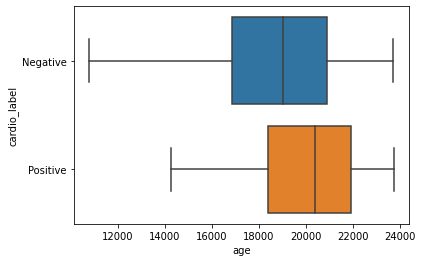

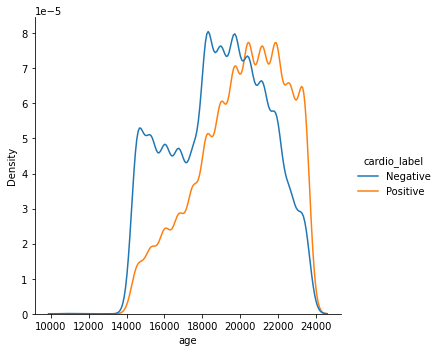

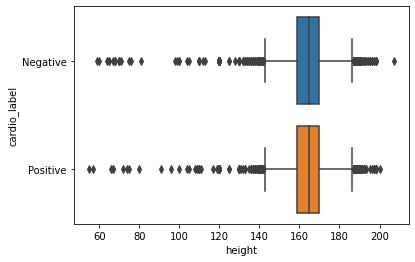

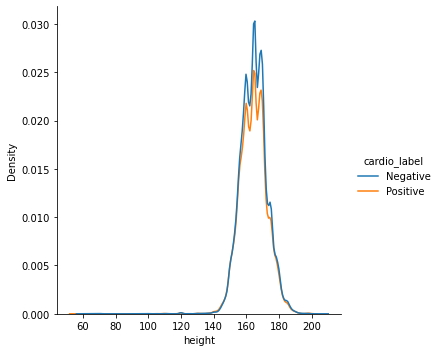

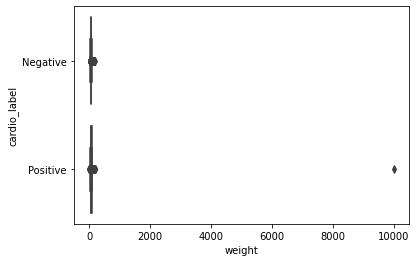

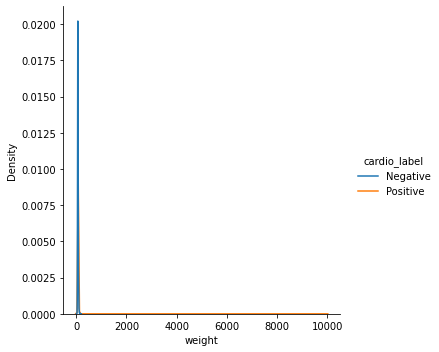

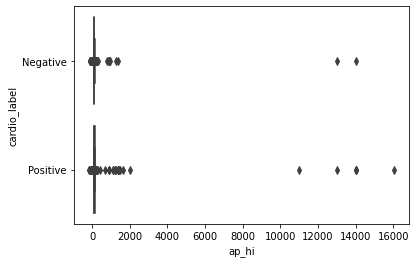

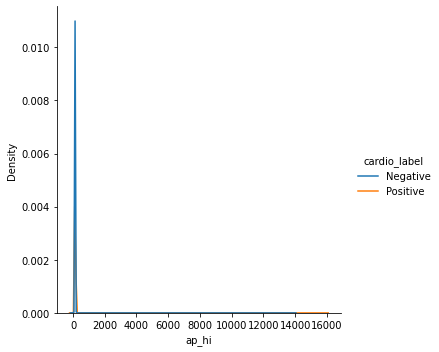

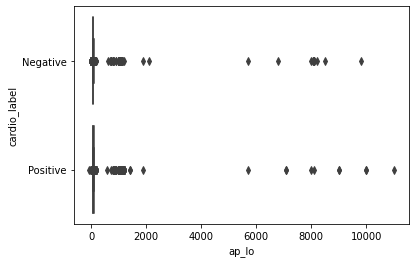

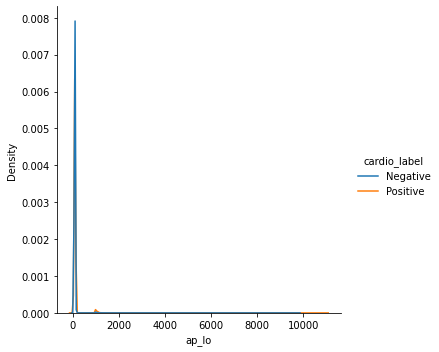

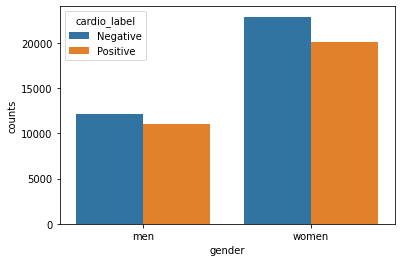

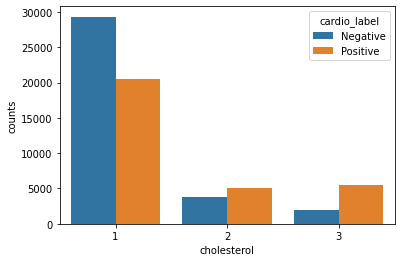

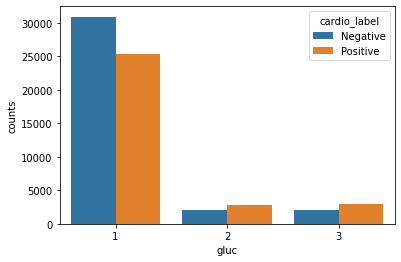

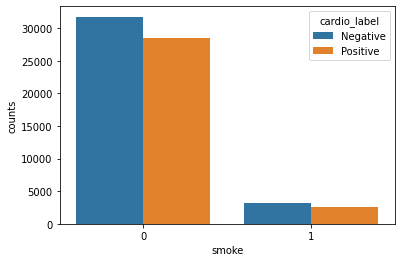

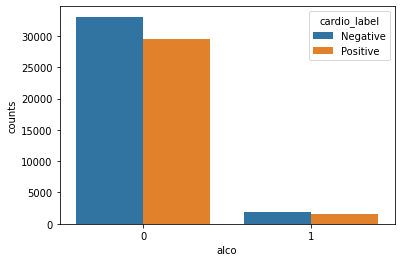

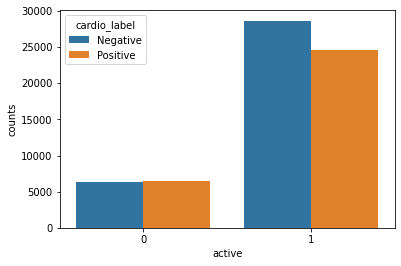

In [10]:
df_pd = df.toPandas()
from matplotlib import pyplot as plt

# visualization
import seaborn as sns

# for numerical data
for c in ['age', 'height', 'weight', 'ap_hi', 'ap_lo']:
    sns.boxplot(data=df_pd, x=c, y = 'cardio_label')
    sns.displot(data=df_pd, x=c, hue='cardio_label', kind="kde")
    plt.show()

# for categorical data
for c in ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']:
    sns.barplot(data=df_pd[[c, 'cardio_label']].groupby(['cardio_label', c]).size().reset_index(name = 'counts'),x = c, y='counts', hue='cardio_label')
    plt.show()

# 2.4 - Data Quality

In [11]:
import numpy as np
# Through the box plots, we can see that there are some outliers in age, height, weight, 
# ap_hi, ap_lo
# use the IQR method to find the lower fence and upper fence
def get_iqr_fence(df_array):
    gap = np.percentile(list(df_array), [25, 75])
    iqr = gap[1] - gap[0]
    lower_fence = gap[0] - 1.5 * iqr
    upper_fence = gap[1] + 1.5 * iqr
    return lower_fence, upper_fence

In [12]:
quality_list_num = []

schema = df.schema
df_pd = df.toPandas()
df_temp = spark.createDataFrame(df_pd,schema=schema)
del df_pd

for c in ['age', 'height', 'weight', 'ap_hi', 'ap_lo']:
    temp_dict = {'col': c, 'missing': df.select([F.count(F.when(F.isnan(c), True)).alias(c)]).collect()[0][c]}
    mean_default = df.filter(~isnan(c)).agg(F.mean(c)).collect()
    df_temp = df_temp.na.fill(mean_default[0][0], subset=[c])
    lower_fence, upper_fence = get_iqr_fence(df_temp.select(c).collect())
    temp_dict.update({
        'lower_fence': lower_fence, 'upper_fence': upper_fence,
        'outliers_number': df_temp.filter( (df_temp[c] < lower_fence) | (df_temp[c] > upper_fence) ).count(),
        'outliers_percent %': round(df_temp.filter( (df_temp[c] < lower_fence) | (df_temp[c] > upper_fence) ).count() * 100 / df_temp.count())
    })
    quality_list_num.append(temp_dict)
    
df_quality_num = pd.DataFrame(quality_list_num)
    
df_quality_num.head(10)

,col,missing,lower_fence,upper_fence,outliers_number,outliers_percent %
0,age,0,12102.5,26824.5,4,0
1,height,2,142.5,186.5,486,1
2,weight,0,39.5,107.5,1685,3
3,ap_hi,0,90.0,170.0,1318,2
4,ap_lo,0,65.0,105.0,4382,7


In [13]:
from pyspark.sql.functions import countDistinct
quality_list_cat = []
for c in ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'mock']:
    quality_list_cat.append({'col': c, 'missing': df.select([F.count(F.when(F.isnan(c), True)).alias(c)]).collect()[0][c], 
                             'possible_values': df.select(countDistinct(c).alias(c)).collect()[0][c]})
    
df_quality_cat = pd.DataFrame(quality_list_cat)
    
df_quality_cat.head(10)

,col,missing,possible_values
0,gender,0,2
1,cholesterol,0,3
2,gluc,0,3
3,smoke,0,2
4,alco,0,2
5,active,0,2
6,mock,33109,2


# 3.1 Data Selection

In [14]:
# drop the column with high percentage of missing value
df = df.drop('mock')
df.show()

+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+------------+
| id|  age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|cardio_label|
+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+------------+
|  0|18393|   men|   NaN|  62.0|  110|   80|          1|   1|    0|   0|     1|     0|    Negative|
|  1|20228| women| 156.0|  85.0|  140|   90|          3|   1|    0|   0|     1|     1|    Positive|
|  2|18857| women| 165.0|  64.0|  130|   70|          3|   1|    0|   0|     0|     1|    Positive|
|  3|17623|   men| 169.0|  82.0|  150|  100|          1|   1|    0|   0|     1|     1|    Positive|
|  4|17474| women|   NaN|  56.0|  100|   60|          1|   1|    0|   0|     0|     0|    Negative|
|  8|21914| women| 151.0|  67.0|  120|   80|          2|   2|    0|   0|     0|     0|    Negative|
|  9|22113| women| 157.0|  93.0|  130|   80|          3|   1|    0|   0|     1|     0|    Negative|


# 3.2 Cleaning the data

## 3.2.1 Handling missing values

In [15]:
mean_height = df.filter(~isnan('height')).agg(F.mean('height')).collect()
df = df.na.fill(mean_height[0][0], subset=['height'])
df_agg = df.agg(
    *[F.count(F.when(F.isnan(c), c)).alias(c) for c in df.columns])
df_agg.show()

+---+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+------------+
| id|age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|cardio_label|
+---+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+------------+
|  0|  0|     0|     0|     0|    0|    0|          0|   0|    0|   0|     0|     0|           0|
+---+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+------------+



## 3.2.2 Handling outliers and extremes

In [16]:
for c in ['age', 'height', 'weight', 'ap_hi', 'ap_lo']:
    print(c, get_iqr_fence(df.select(c).collect()))

age (12102.5, 26824.5)
height (142.5, 186.5)
weight (39.5, 107.5)
ap_hi (90.0, 170.0)
ap_lo (65.0, 105.0)


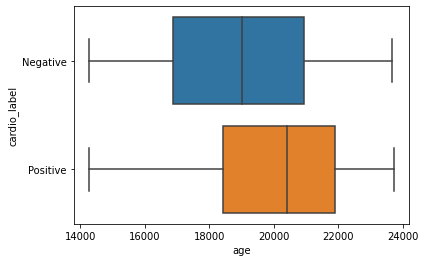

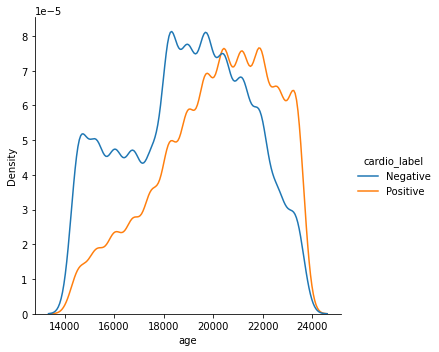

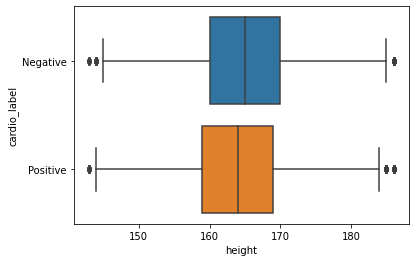

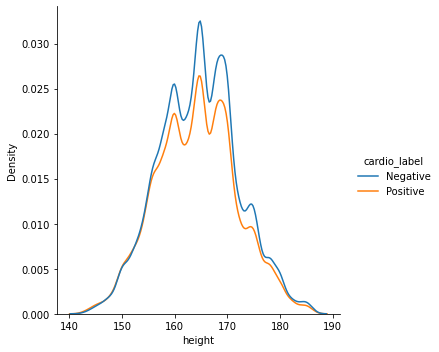

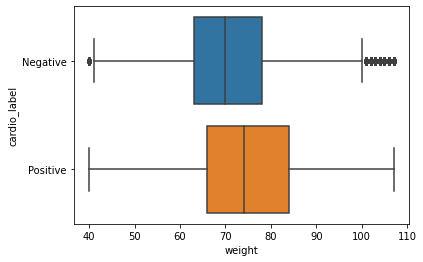

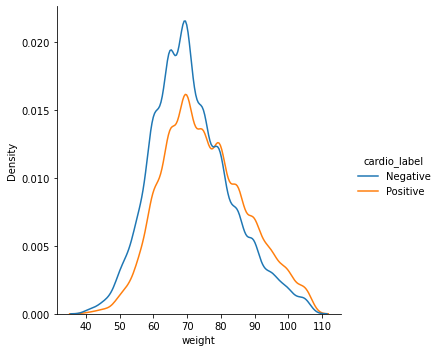

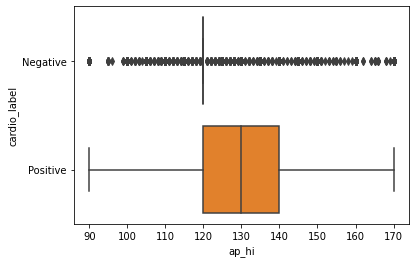

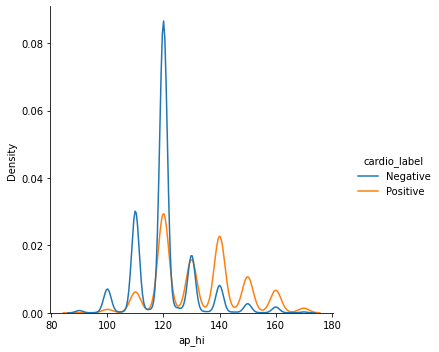

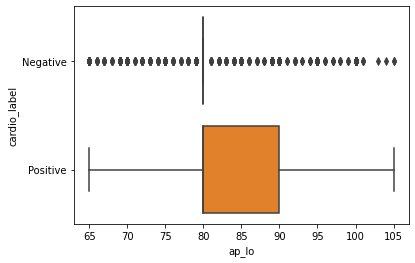

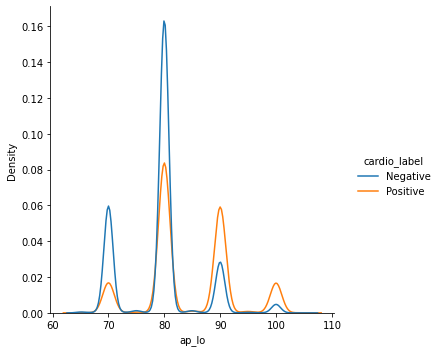

In [17]:
# the range make sense
# then filter the outliers
df_filter = spark.createDataFrame(df.toPandas(),schema=df.schema)
for c in ['age', 'height', 'weight', 'ap_hi', 'ap_lo']:
    lower_fence, upper_fence = get_iqr_fence(df_filter.select(c).collect())
    df_filter = df_filter.filter( (df_filter[c] >= lower_fence) & (df_filter[c] <= upper_fence) )
    
#     df_filter = df_filter[(df_filter[c] >= lower_fence) & (df_filter[c] <= upper_fence)]
#     df_filter.reset_index(inplace = True, drop = True)

df_filter_pd = df_filter.toPandas()

# plot again
# for prepocessing numerical data
for c in ['age', 'height', 'weight', 'ap_hi', 'ap_lo']:
    sns.boxplot(data=df_filter_pd, x=c, y = 'cardio_label')
    sns.displot(data=df_filter_pd, x=c, hue='cardio_label', kind="kde")
    plt.show()

# 3.3 Constructing/Deriving a New Feature

In [18]:
# age constructing
from pyspark.sql.functions import col

df_filter = df_filter.withColumn("age", col("age") / 365)

df_ap_agg = df_filter.groupBy("cardio").agg(avg('age').alias("avg_age"), min('age').alias("min_age"), 
                         max('age').alias("max_age"))
df_ap_agg.selectExpr('cardio','round(avg_age, 2) as avg_age','round(min_age, 2) as min_age','round(max_age, 2) as max_age').show()

+------+-------+-------+-------+
|cardio|avg_age|min_age|max_age|
+------+-------+-------+-------+
|     0|  51.83|  39.13|  64.87|
|     1|  55.03|  39.14|  64.97|
+------+-------+-------+-------+



In [22]:
# age categorize
def get_age_category(x):
    if  x < 50:
        return 'Adults'
    elif x < 60:
        return 'Middle-aged'
    else:
        return 'Elderly'

In [23]:
from pyspark.sql.types import *
UDF = F.udf(get_age_category, StringType())
df_filter = df_filter.withColumn("age_refeature", UDF("age"))

In [24]:
df_filter.groupBy('age_refeature').count().show()

+-------------+-----+
|age_refeature|count|
+-------------+-----+
|  Middle-aged|30081|
|      Elderly|10903|
|       Adults|18058|
+-------------+-----+



In [74]:
# reclassify gender
# then convert gender: 0: women, 1: man

dictionary_gender = {'women': '1', 'men': '2'}

mapping_gender = create_map([lit(x) for x in chain(*dictionary_gender.items())])
df_filter = df_filter.withColumn('gender', mapping_gender[col('gender')])

In [75]:
# construct new feature BMI
df_filter = df_filter.withColumn('bmi', col('weight')*10000/(col('height')*col('height')))

# df_filter['bmi'] = df_filter['weight'] * 10000 / (df_filter['height'] * df_filter['height'])

In [76]:
# print(df_filter[['ap_hi', 'ap_lo']].corr())
print('ap_hi', 'ap_lo', df_filter.corr('ap_hi', 'ap_lo'))
# print(round(df_filter[['ap_hi','ap_lo', 'cardio']].groupby('cardio').describe().transpose(), 2))
df_ap_agg = df_filter.groupBy("cardio").agg(avg('ap_hi').alias("avg_ap_hi"), min('ap_hi').alias("min_ap_hi"), 
                         max('ap_hi').alias("max_ap_hi"),avg('ap_lo').alias("avg_ap_lo"), min('ap_lo').alias("min_ap_lo"), 
                         max('ap_lo').alias("max_ap_lo"))
df_ap_agg.selectExpr('cardio','round(avg_ap_hi, 2) as avg_ap_hi','round(min_ap_hi, 2) as min_ap_hi','round(max_ap_hi, 2) as max_ap_hi',
                 'round(avg_ap_lo, 2) as avg_ap_lo','round(min_ap_lo, 2) as min_ap_lo', 'round(max_ap_lo, 2) as max_ap_lo').show()

ap_hi ap_lo 0.7062257727114598
+------+---------+---------+---------+---------+---------+---------+
|cardio|avg_ap_hi|min_ap_hi|max_ap_hi|avg_ap_lo|min_ap_lo|max_ap_lo|
+------+---------+---------+---------+---------+---------+---------+
|     0|   120.32|       90|      170|    79.15|       65|      105|
|     1|   132.71|       90|      170|    84.31|       65|      105|
+------+---------+---------+---------+---------+---------+---------+



In [77]:
# construct new feature ap_gap and ap_mul
df_filter = df_filter.withColumn('ap_gap', col('ap_hi') - col('ap_lo'))
df_filter = df_filter.withColumn('ap_mul', col('ap_hi') * col('ap_lo'))

df_ap_agg = df_filter.groupBy("cardio").agg(avg('ap_gap').alias("avg_ap_gap"), min('ap_gap').alias("min_ap_gap"), 
                         max('ap_gap').alias("max_ap_gap"),avg('ap_mul').alias("avg_ap_mul"), min('ap_mul').alias("min_ap_mul"), 
                         max('ap_mul').alias("max_ap_mul"))
df_ap_agg.selectExpr('cardio','round(avg_ap_gap, 2) as avg_ap_gap','round(min_ap_gap, 2) as min_ap_gap','round(max_ap_gap, 2) as max_ap_gap',
                 'round(avg_ap_mul, 2) as avg_ap_mul','round(min_ap_mul, 2) as min_ap_mul', 'round(max_ap_mul, 2) as max_ap_mul').show()

+------+----------+----------+----------+----------+----------+----------+
|cardio|avg_ap_gap|min_ap_gap|max_ap_gap|avg_ap_mul|min_ap_mul|max_ap_mul|
+------+----------+----------+----------+----------+----------+----------+
|     0|     41.17|       -10|       103|   9568.78|      5850|     17472|
|     1|      48.4|        -5|       100|  11265.77|      5850|     17680|
+------+----------+----------+----------+----------+----------+----------+



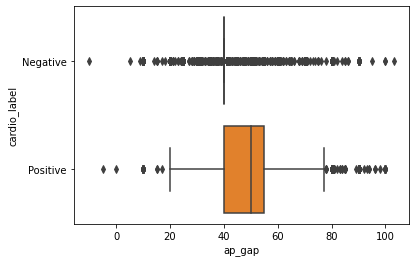

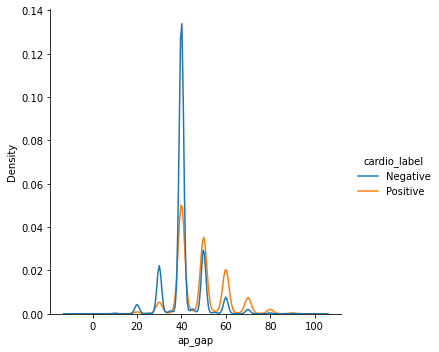

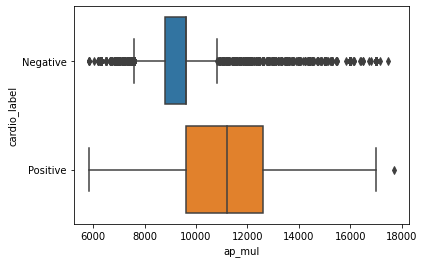

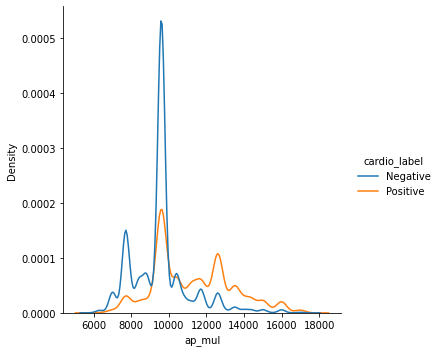

In [78]:
df_filter_pd = df_filter.toPandas()

# plot again
# for prepocessing numerical data
for c in ['ap_gap', 'ap_mul']:
    sns.boxplot(data=df_filter_pd, x=c, y = 'cardio_label')
    sns.displot(data=df_filter_pd, x=c, hue='cardio_label', kind="kde")
    plt.show()

In [79]:
# print(df_filter[['bmi', 'ap_hi']].corr())
print('bmi', 'ap_hi', df_filter.corr('bmi', 'ap_hi'))
df_ap_agg = df_filter.groupBy("cardio").agg(avg('bmi').alias("avg_bmi"), min('bmi').alias("min_bmi"), 
                         max('bmi').alias("max_bmi"),avg('ap_hi').alias("avg_ap_hi"), min('ap_hi').alias("min_ap_hi"), 
                         max('ap_hi').alias("max_ap_hi"))
df_ap_agg.selectExpr('cardio','round(avg_bmi, 2) as avg_bmi','round(min_bmi, 2) as min_bmi','round(max_bmi, 2) as max_bmi',
                 'round(avg_ap_hi, 2) as avg_ap_hi','round(min_ap_hi, 2) as min_ap_hi', 'round(max_ap_hi, 2) as max_ap_hi').show()

bmi ap_hi 0.24300173648927936
+------+-------+-------+-------+---------+---------+---------+
|cardio|avg_bmi|min_bmi|max_bmi|avg_ap_hi|min_ap_hi|max_ap_hi|
+------+-------+-------+-------+---------+---------+---------+
|     0|  26.31|  14.61|  49.73|   120.32|       90|      170|
|     1|  27.94|  13.52|  50.89|   132.71|       90|      170|
+------+-------+-------+-------+---------+---------+---------+



In [80]:
# consttruct new feature bmi_aphi

df_filter = df_filter.withColumn('bmi_aphi', (col('bmi') - col('ap_hi'))**2)

df_ap_agg = df_filter.groupBy("cardio").agg(avg('bmi_aphi').alias("avg_bmi_aphi"), min('bmi_aphi').alias("min_bmi_aphi"), 
                         max('bmi_aphi').alias("max_bmi_aphi"))
df_ap_agg.selectExpr('cardio','round(avg_bmi_aphi, 2) as avg_bmi_aphi','round(min_bmi_aphi, 2) as min_bmi_aphi','round(max_bmi_aphi, 2) as max_bmi_aphi').show()

+------+------------+------------+------------+
|cardio|avg_bmi_aphi|min_bmi_aphi|max_bmi_aphi|
+------+------------+------------+------------+
|     0|     8950.25|     2825.93|    22140.52|
|     1|    11193.14|     3112.99|    22993.03|
+------+------------+------------+------------+



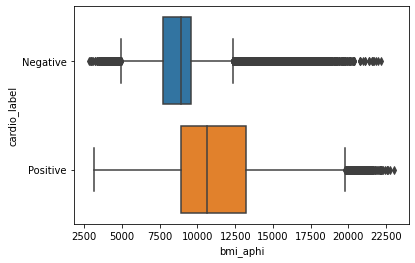

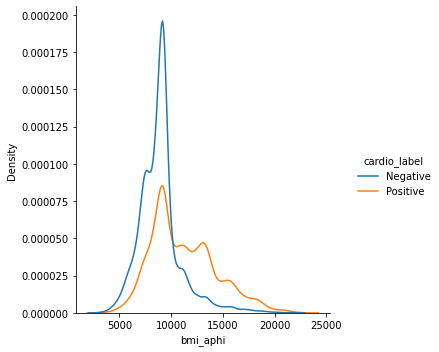

In [81]:
df_filter_pd = df_filter.toPandas()

# plot again
# for prepocessing numerical data
sns.boxplot(data=df_filter_pd, x='bmi_aphi', y = 'cardio_label')
sns.displot(data=df_filter_pd, x='bmi_aphi', hue='cardio_label', kind="kde")
plt.show()

# 3.4Data Integration

In [82]:
# merge dataset
df_creff = pd.read_excel('dataset/creff.xlsx')
df_creff = spark.createDataFrame(df_creff)

df_filter = df_filter.join(df_creff, df_filter.id == df_creff.id, 'inner')

In [83]:
df_filter.select('creff').show()

+------------------+
|             creff|
+------------------+
| 61.16424657534246|
|  71.0906301369863|
| 71.59586301369863|
| 58.78997260273973|
| 63.73430136986301|
| 65.04213698630137|
|  66.3536712328767|
| 62.18112328767124|
|58.436876712328775|
| 60.49898630136987|
| 60.10643835616439|
| 54.33682191780822|
| 58.85408219178082|
|  72.6674794520548|
| 75.29104109589042|
|  56.6906301369863|
| 61.92468493150685|
|57.601232876712324|
| 71.97139726027397|
| 62.96597260273972|
+------------------+
only showing top 20 rows



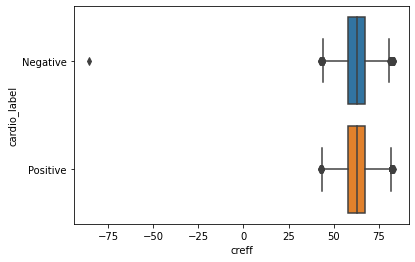

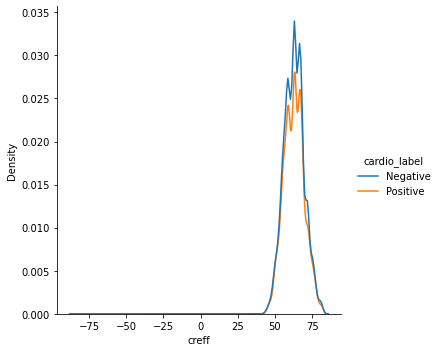

In [84]:
# plot
df_filter_pd = df_filter.toPandas()
sns.boxplot(data=df_filter_pd, x='creff', y = 'cardio_label')
sns.displot(data=df_filter_pd, x='creff', hue='cardio_label', kind="kde")
plt.show()

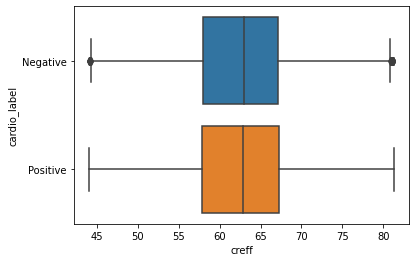

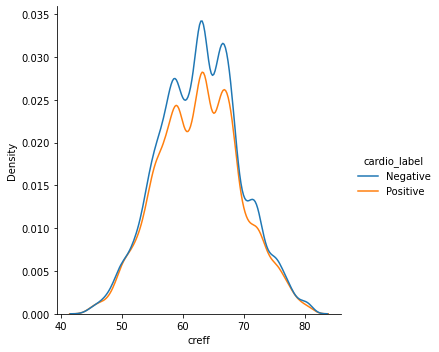

In [85]:
# deal with outliers
lower_fence, upper_fence = get_iqr_fence(df_filter.select('creff').collect())
df_filter = df_filter.filter( (df_filter['creff'] >= lower_fence) & (df_filter['creff'] <= upper_fence) )

# plot again
df_filter_pd = df_filter.toPandas()
sns.boxplot(data=df_filter_pd, x='creff', y = 'cardio_label')
sns.displot(data=df_filter_pd, x='creff', hue='cardio_label', kind="kde")
plt.show()

# 4.Data Transformation

In [86]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import (RandomForestClassifier, GBTClassifier, DecisionTreeClassifier)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [87]:
df_filter.printSchema()

root
 |-- id: long (nullable = true)
 |-- age: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- height: double (nullable = false)
 |-- weight: double (nullable = true)
 |-- ap_hi: long (nullable = true)
 |-- ap_lo: long (nullable = true)
 |-- cholesterol: long (nullable = true)
 |-- gluc: long (nullable = true)
 |-- smoke: long (nullable = true)
 |-- alco: long (nullable = true)
 |-- active: long (nullable = true)
 |-- cardio: long (nullable = true)
 |-- cardio_label: string (nullable = true)
 |-- age_refeature: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- ap_gap: long (nullable = true)
 |-- ap_mul: long (nullable = true)
 |-- bmi_aphi: double (nullable = true)
 |-- id: long (nullable = true)
 |-- creff: double (nullable = true)



In [88]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, StandardScaler
# Convert the categorical labels in the 'Species' column to numerical values
label_indexer = StringIndexer(inputCol="cardio", outputCol="label")
data = label_indexer.fit(df_filter).transform(df_filter)

data = data.withColumn('gender', data.gender.cast('int'))

# Assemble the feature columns into a single vector column
assembler = VectorAssembler(inputCols=['age', 'height', 'weight', 'ap_hi', 
                                       'ap_lo', 'bmi', 'creff', 
                                       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 
                                       'gender', 'ap_gap', 'ap_mul', 'bmi_aphi'], outputCol="features",handleInvalid="skip")
data = assembler.transform(data)


In [95]:
dt_classifier = DecisionTreeClassifier(labelCol="label", featuresCol="features")
model = dt_classifier.fit(data)
print(list(zip(assembler.getInputCols(), model.featureImportances)))

[('age', 0.10529286733858252), ('height', 0.0), ('weight', 0.0), ('ap_hi', 0.8013787807396513), ('ap_lo', 0.0), ('bmi', 0.0034905864208185093), ('creff', 0.0), ('cholesterol', 0.07730044348334365), ('gluc', 0.005458943346115292), ('smoke', 0.0006061722232781559), ('alco', 0.0), ('active', 0.0017924661763522834), ('gender', 0.0), ('ap_gap', 0.004215378777602431), ('ap_mul', 0.0), ('bmi_aphi', 0.0004643614942558809)]


In [101]:
dt_important_df = pd.DataFrame({'col': assembler.getInputCols(), 'importance': list(model.featureImportances)})
dt_important_df.sort_values(by = 'importance', ascending = False, inplace = True)
dt_important_df.head(20)

,col,importance
3,ap_hi,0.801379
0,age,0.105293
7,cholesterol,0.077300
8,gluc,0.005459
13,ap_gap,0.004215
5,bmi,0.003491
11,active,0.001792
9,smoke,0.000606
15,bmi_aphi,0.000464
1,height,0.000000


# 4.2 Data Projection

In [90]:
# standardization

# Define StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)

# Compute summary statistics and generate StandardScalerModel
scalerModel = scaler.fit(data)

# Normalize each feature to have unit standard deviation and zero mean
scaledData = scalerModel.transform(data)

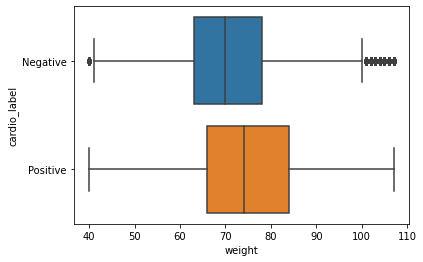

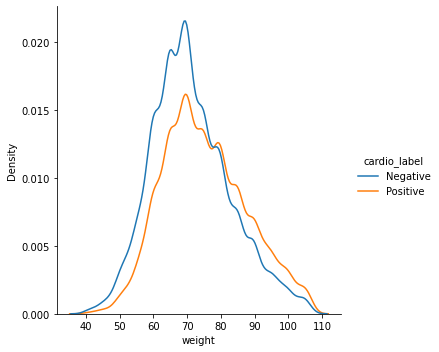

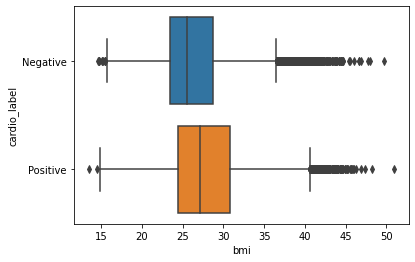

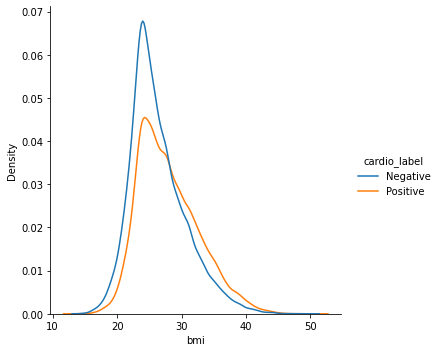

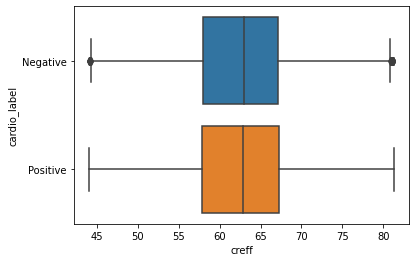

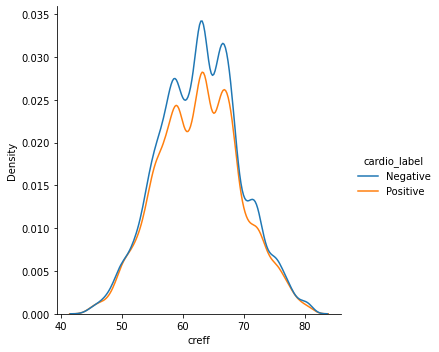

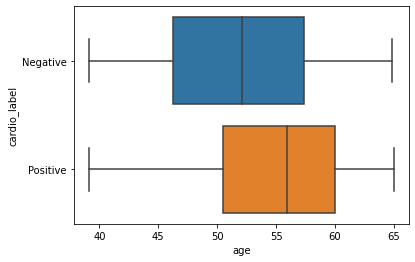

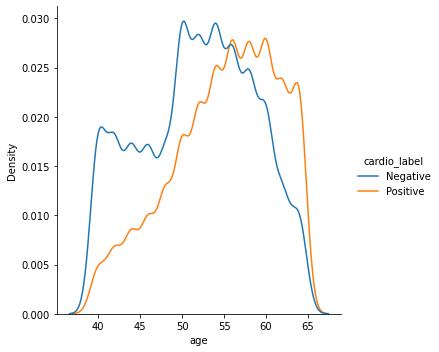

In [91]:
df_filter_pd = scaledData.toPandas()
for c in ['weight', 'bmi', 'creff', 'age']:
    sns.boxplot(data=df_filter_pd, x=c, y = 'cardio_label')
    sns.displot(data=df_filter_pd, x=c, hue='cardio_label', kind="kde")
    plt.show()

In [92]:
# Boost the imbalance of target label
# then deal with the imbalance of target
from pyspark.sql.functions import explode, array
#spliting df by classes
major_df = scaledData.filter(col('cardio') == 0)
minor_df = scaledData.filter(col('cardio') == 1)
#ratio of number observation major vs minor class
r = int(major_df.count()/minor_df.count())
 
# duplicate the minority rows
boostData = minor_df.withColumn("dummy", explode(array([lit(x) for x in range(r)]))).drop('dummy').sample(True, 0.15, 42)

boostData = scaledData.unionAll(boostData)
print('boostData')
boostData.groupBy('cardio').count().show()
print('scaledData')
scaledData.groupBy('cardio').count().show()

boostData


+------+-----+
|cardio|count|
+------+-----+
|     0|31535|
|     1|31421|
+------+-----+

scaledData
+------+-----+
|cardio|count|
+------+-----+
|     0|31535|
|     1|27313|
+------+-----+



# 6. Data-Mining Algorithms Selection

In [93]:
train_data, test_data = boostData.randomSplit([.9,.1])

## 6.1.1 Data Mining Objective: CART algorithm

In [94]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

evaluatorMulti = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
evaluator = BinaryClassificationEvaluator(labelCol="label")

dtc = DecisionTreeClassifier(labelCol='label',featuresCol='scaledFeatures')
dtc_model = dtc.fit(train_data)
dtc_predictions = dtc_model.transform(test_data)

print("DTC")
predictionAndTarget = dtc_model.transform(test_data).select("label", "prediction")
# Get metrics
acc = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "accuracy"})
f1 = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "f1"})
weightedPrecision = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecall = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedRecall"})
auc = evaluator.evaluate(dtc_predictions)
print('ACCURACY: %.4f'%acc, 'F1: %.4f'%f1, 'auc: %.4f'%auc)

DTC


ACCURACY: 0.7181 F1: 0.7162 auc: 0.5775


## 6.1.2 Data Mining Objective: Logistic Regression algorithm

In [52]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

evaluatorMulti = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
evaluator = BinaryClassificationEvaluator(labelCol="label")

lrc = LogisticRegression(labelCol='label',featuresCol='scaledFeatures')
lrc_model = lrc.fit(train_data)
lrc_predictions = lrc_model.transform(test_data)

print("LRC")
predictionAndTarget = lrc_model.transform(test_data).select("label", "prediction")
# Get metrics
acc = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "accuracy"})
f1 = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "f1"})
weightedPrecision = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecall = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedRecall"})
auc = evaluator.evaluate(lrc_predictions)
print('ACCURACY: %.4f'%acc, 'F1: %.4f'%f1, 'auc: %.4f'%auc)

LRC


ACCURACY: 0.7197 F1: 0.7189 auc: 0.7849


## 6.1.3 Data Mining Objective: Random Forest

In [53]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

evaluatorMulti = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
evaluator = BinaryClassificationEvaluator(labelCol="label")

rfc = RandomForestClassifier(labelCol='label',featuresCol='scaledFeatures')
rfc_model = rfc.fit(train_data)
rfc_predictions = rfc_model.transform(test_data)

print("RFC")
predictionAndTarget = rfc_model.transform(test_data).select("label", "prediction")
# Get metrics
acc = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "accuracy"})
f1 = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "f1"})
weightedPrecision = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecall = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedRecall"})
auc = evaluator.evaluate(rfc_predictions)
print('ACCURACY: %.4f'%acc, 'F1: %.4f'%f1, 'auc: %.4f'%auc)

RFC


ACCURACY: 0.7167 F1: 0.7155 auc: 0.7645


## 6.1.4 Data Mining Objective: XGBoost

In [54]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

evaluatorMulti = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
evaluator = BinaryClassificationEvaluator(labelCol="label")

xgc = SparkXGBClassifier(features_col="scaledFeatures", label_col="label",)
xgc_model = xgc.fit(train_data)
xgc_predictions = xgc_model.transform(test_data)

print("XGC")
predictionAndTarget = rfc_model.transform(test_data).select("label", "prediction")
# Get metrics
acc = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "accuracy"})
f1 = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "f1"})
weightedPrecision = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecall = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedRecall"})
auc = evaluator.evaluate(xgc_predictions)
print('ACCURACY: %.4f'%acc, 'F1: %.4f'%f1, 'auc: %.4f'%auc)

2023-10-12 08:04:52,534 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[08:04:57] task 0 got new rank 0                                    (0 + 1) / 1]
2023-10-12 08:04:58,794 INFO XGBoost-PySpark: _fit Finished xgboost training!   


XGC


INFO:XGBoost-PySpark:Do the inference on the CPUs                               
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs                   (2 + 2) / 4]
2023-10-12 08:05:10,735 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


ACCURACY: 0.7167 F1: 0.7155 auc: 0.7935


col: height importance: 444.0
col: weight importance: 604.0
col: ap_hi importance: 122.0
col: ap_lo importance: 153.0
col: bmi importance: 543.0
col: creff importance: 922.0
col: cholesterol importance: 179.0
col: gluc importance: 134.0
col: smoke importance: 84.0
col: alco importance: 46.0
col: active importance: 110.0
col: gender importance: 74.0
col: ap_gap importance: 207.0
col: ap_mul importance: 247.0
col: bmi_aphi importance: 798.0


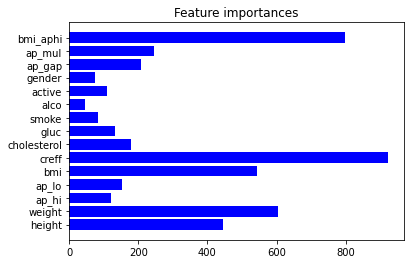

In [55]:
col_list = []
importance_list = []
for c, v in zip(assembler.getInputCols(), xgc_model.get_feature_importances().values()):
    col_list.append(c)
    importance_list.append(v)
    print('col: %s'%c, 'importance: %.1f'%v)

plt.figure()
plt.title("Feature importances")
plt.barh(col_list, importance_list, color="b")
plt.show()

# 6.3 Build/Select Model with Algorithm/Model Parameters

In [42]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

evaluatorMulti = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
evaluator = BinaryClassificationEvaluator(labelCol="label")

xgc = SparkXGBClassifier(features_col="scaledFeatures",
                         label_col="label",max_depth = 5, n_estimators = 100)
xgc_model = xgc.fit(train_data)
xgc_predictions = xgc_model.transform(test_data)

print("XGC")
predictionAndTarget = xgc_model.transform(test_data).select("label", "prediction")
# Get metrics
acc = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "accuracy"})
f1 = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "f1"})
weightedPrecision = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecall = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedRecall"})
auc = evaluator.evaluate(xgc_predictions)
print('ACCURACY: %.4f'%acc, 'F1: %.4f'%f1, 'auc: %.4f'%auc)

2023-10-12 07:11:31,345 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 5, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[07:11:35] task 0 got new rank 0                                    (0 + 1) / 1]
2023-10-12 07:11:36,787 INFO XGBoost-PySpark: _fit Finished xgboost training!   


XGC


2023-10-12 07:11:39,330 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-12 07:11:39,752 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs                   (2 + 2) / 4]
INFO:XGBoost-PySpark:Do the inference on the CPUs                               
2023-10-12 07:11:42,112 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2023-10-12 07:11:42,634 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-12 07:11:44,684 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-12 07:11:45,131 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2023-10-12 07:11:47,314 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the i

ACCURACY: 0.7264 F1: 0.7256 auc: 0.7935


# 7.Data Mining


## 7.1 Creating Logical Tests

In [43]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

evaluatorMulti = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
evaluator = BinaryClassificationEvaluator(labelCol="label")

xgc = SparkXGBClassifier(features_col="scaledFeatures",
                         label_col="label",max_depth = 5, n_estimators = 20)
xgc_model = xgc.fit(train_data)
xgc_predictions_test = xgc_model.transform(test_data)
xgc_predictions_train = xgc_model.transform(train_data)

print("XGC")
predictionAndTargetTrain = xgc_model.transform(train_data).select("label", "prediction")
predictionAndTargetTest = xgc_model.transform(test_data).select("label", "prediction")
# Get metrics
acc_train = evaluatorMulti.evaluate(predictionAndTargetTrain, {evaluatorMulti.metricName: "accuracy"})
acc_test = evaluatorMulti.evaluate(predictionAndTargetTest, {evaluatorMulti.metricName: "accuracy"})
f1_train = evaluatorMulti.evaluate(predictionAndTargetTrain, {evaluatorMulti.metricName: "f1"})
f1_test = evaluatorMulti.evaluate(predictionAndTargetTest, {evaluatorMulti.metricName: "f1"})
auc_train = evaluator.evaluate(xgc_predictions_train)
auc_test = evaluator.evaluate(xgc_predictions_test)
print('train  ','ACCURACY: %.4f'%acc_train, 'F1: %.4f'%f1_train, 'auc: %.4f'%auc_train)
print('test   ','ACCURACY: %.4f'%acc_test, 'F1: %.4f'%f1_test, 'auc: %.4f'%auc_test)

2023-10-12 07:11:55,295 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 5, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 20}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[07:11:58] task 0 got new rank 0                                    (0 + 1) / 1]
2023-10-12 07:12:00,156 INFO XGBoost-PySpark: _fit Finished xgboost training!   


XGC


INFO:XGBoost-PySpark:Do the inference on the CPUs                               
2023-10-12 07:12:02,825 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2023-10-12 07:12:03,248 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs                               
2023-10-12 07:12:05,738 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs                   (2 + 2) / 4]
2023-10-12 07:12:06,104 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2023-10-12 07:12:08,305 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-12 07:12:08,854 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-12 07:12:11,131 INFO XGBoost-PySpark: predict_udf Do the inference on the CPU

train   ACCURACY: 0.7309 F1: 0.7295 auc: 0.7981
test    ACCURACY: 0.7224 F1: 0.7210 auc: 0.7831


col: height importance: 57.0
col: weight importance: 58.0
col: ap_hi importance: 32.0
col: ap_lo importance: 16.0
col: bmi importance: 91.0
col: creff importance: 102.0
col: cholesterol importance: 36.0
col: gluc importance: 26.0
col: smoke importance: 13.0
col: alco importance: 11.0
col: active importance: 15.0
col: gender importance: 6.0
col: ap_gap importance: 18.0
col: ap_mul importance: 38.0
col: bmi_aphi importance: 71.0


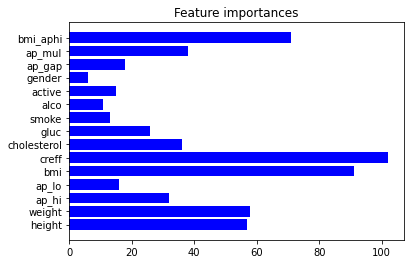

In [44]:
col_list = []
importance_list = []
for c, v in zip(assembler.getInputCols(), xgc_model.get_feature_importances().values()):
    col_list.append(c)
    importance_list.append(v)
    print('col: %s'%c, 'importance: %.1f'%v)

plt.figure()
plt.title("Feature importances")
plt.barh(col_list, importance_list, color="b")
plt.show()

In [46]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

evaluatorMulti = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
evaluator = BinaryClassificationEvaluator(labelCol="label")

test_size_performance = []

for i in range(6):
    test_size = 0.05 + i * 0.05
    train_data_temp, test_data_temp = boostData.randomSplit([1-test_size, test_size])
    xgc = SparkXGBClassifier(features_col="scaledFeatures",
                                 label_col="label",max_depth = 6, n_estimators = 200)
    xgc_model = xgc.fit(train_data_temp)
    xgc_predictions = xgc_model.transform(test_data_temp)
    predictionAndTarget = xgc_model.transform(test_data_temp).select("label", "prediction")
    # Get metrics
    acc = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "accuracy"})
    f1 = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "f1"})
    weightedPrecision = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedPrecision"})
    weightedRecall = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedRecall"})
    auc = evaluator.evaluate(xgc_predictions)
    test_size_performance.append({'test_size': test_size, 'accuracy': acc, 'f1': f1, 'auc': auc})
    print('test size: %.2f'%test_size, 'ACCURACY: %.4f'%acc, 'F1: %.4f'%f1, 'auc: %.4f'%auc)

test_size_df = pd.DataFrame(test_size_performance)
test_size_df.head(10)

2023-10-12 07:26:53,083 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 6, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[07:26:56] task 0 got new rank 0                                    (0 + 1) / 1]
2023-10-12 07:26:58,803 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs                               
2023-10-12 07:27:01,043 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-12 07:27:01,470 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-12 07:27:03,669 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inferenc

test size: 0.05 ACCURACY: 0.7214 F1: 0.7205 auc: 0.7876


2023-10-12 07:27:16,096 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 6, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[07:27:19] task 0 got new rank 0                                    (0 + 1) / 1]
2023-10-12 07:27:21,785 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs                               
2023-10-12 07:27:23,922 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-12 07:27:24,153 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs=====>             (3 + 1) / 4]
INFO:XGBoost-PySpark:Do the inference on the CPUs                               
2023-10-12 

test size: 0.10 ACCURACY: 0.7217 F1: 0.7212 auc: 0.7853


2023-10-12 07:27:38,156 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 6, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[07:27:41] task 0 got new rank 0                                    (0 + 1) / 1]
2023-10-12 07:27:43,684 INFO XGBoost-PySpark: _fit Finished xgboost training!   
2023-10-12 07:27:45,855 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs                   (2 + 2) / 4]
2023-10-12 07:27:46,335 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-12 07:27:48,323 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inferenc

test size: 0.15 ACCURACY: 0.7284 F1: 0.7279 auc: 0.7923


2023-10-12 07:27:59,510 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 6, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[07:28:02] task 0 got new rank 0                                    (0 + 1) / 1]
2023-10-12 07:28:05,024 INFO XGBoost-PySpark: _fit Finished xgboost training!   
2023-10-12 07:28:07,084 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-12 07:28:07,621 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs                               
2023-10-12 07:28:09,635 INFO XGBoost-PySpark: predict_udf Do the inferenc

test size: 0.20 ACCURACY: 0.7297 F1: 0.7293 auc: 0.7915


2023-10-12 07:28:21,031 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 6, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[07:28:24] task 0 got new rank 0                                    (0 + 1) / 1]
2023-10-12 07:28:26,327 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs                               
2023-10-12 07:28:28,379 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs                   (2 + 2) / 4]
2023-10-12 07:28:28,920 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-12 07:28:30,691 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:

test size: 0.25 ACCURACY: 0.7212 F1: 0.7207 auc: 0.7857


2023-10-12 07:28:43,160 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 6, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[07:28:46] task 0 got new rank 0                                    (0 + 1) / 1]
2023-10-12 07:28:48,446 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs                               
2023-10-12 07:28:50,537 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs                   (2 + 2) / 4]
2023-10-12 07:28:50,947 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs                               
2023-10-12 

test size: 0.30 ACCURACY: 0.7241 F1: 0.7235 auc: 0.7879


,test_size,accuracy,f1,auc
0,0.05,0.721387,0.720473,0.787650
1,0.10,0.721717,0.721209,0.785254
2,0.15,0.728403,0.727899,0.792274
3,0.20,0.729725,0.729316,0.791546
4,0.25,0.721153,0.720696,0.785692
5,0.30,0.724121,0.723515,0.787916


In [44]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Create both evaluators
evaluatorMulti = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
evaluator = BinaryClassificationEvaluator(labelCol="label")

train_data_temp, test_data_temp = boostData.randomSplit([0.85, 0.15])

result_list = []
for md in range(5, 11):
    for ne in range(1, 6):
        xgc = SparkXGBClassifier(features_col="scaledFeatures",
                                 label_col="label",max_depth = md, n_estimators = 50*ne)
        xgc_model = xgc.fit(train_data_temp)
        xgc_predictions = xgc_model.transform(test_data_temp)
        # Make predicitons
        predictionAndTarget = xgc_model.transform(test_data_temp).select("label", "prediction")

        # Get metrics
        acc = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "accuracy"})
        f1 = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "f1"})
        weightedPrecision = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedPrecision"})
        weightedRecall = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedRecall"})
        auc = evaluator.evaluate(xgc_predictions)
        result_list.append({'max_depth': md, 'n_estimators': 50*ne, 'accuracy': acc, 'f1': f1, 'auc': auc})
        print('MAX_DEPTH: %d'%md, 'N_ESTIMATORS: %d'%(50*ne), 'ACCURACY: %.4f'%acc, 'F1: %.4f'%f1, 'auc: %.4f'%auc)

2023-10-12 06:15:23,811 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 5, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 50}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 5, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 50}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[06:15:27] task 0 got new rank 0                                    (0 + 1) / 1]
2023-10-12 06:15:28,666 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Do the inference on the CPUs                               
2023-10-12 06:15:32,614 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the infere

MAX_DEPTH: 5 N_ESTIMATORS: 50 ACCURACY: 0.7301 F1: 0.7293 auc: 0.7932


2023-10-12 06:15:54,561 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 5, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 5, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[06:15:59] task 0 got new rank 0                                    (0 + 1) / 1]
2023-10-12 06:16:01,320 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Do the inference on the CPUs                               
2023-10-12 06:16:04,576 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the infe

MAX_DEPTH: 5 N_ESTIMATORS: 100 ACCURACY: 0.7314 F1: 0.7308 auc: 0.7971


2023-10-12 06:16:29,278 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 5, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 5, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[06:16:34] task 0 got new rank 0                                    (0 + 1) / 1]
2023-10-12 06:16:35,975 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Finished xgboost training!
2023-10-12 06:16:39,517 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-

MAX_DEPTH: 5 N_ESTIMATORS: 150 ACCURACY: 0.7316 F1: 0.7311 auc: 0.7971


2023-10-12 06:17:03,329 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 5, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 5, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[06:17:07] task 0 got new rank 0                                    (0 + 1) / 1]
2023-10-12 06:17:10,123 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Do the inference on the CPUs                               
2023-10-12 06:17:13,724 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the infe

MAX_DEPTH: 5 N_ESTIMATORS: 200 ACCURACY: 0.7294 F1: 0.7289 auc: 0.7971


2023-10-12 06:17:37,210 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 5, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 250}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 5, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 250}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[06:17:41] task 0 got new rank 0                                    (0 + 1) / 1]
2023-10-12 06:17:44,194 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Do the inference on the CPUs                               
2023-10-12 06:17:47,790 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the infe

MAX_DEPTH: 5 N_ESTIMATORS: 250 ACCURACY: 0.7329 F1: 0.7325 auc: 0.7971


2023-10-12 06:18:12,456 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 6, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 50}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 6, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 50}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[06:18:15] task 0 got new rank 0                                    (0 + 1) / 1]
2023-10-12 06:18:17,134 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Do the inference on the CPUs                               
2023-10-12 06:18:19,393 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the infere

MAX_DEPTH: 6 N_ESTIMATORS: 50 ACCURACY: 0.7333 F1: 0.7326 auc: 0.7962


2023-10-12 06:18:32,995 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 6, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 6, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[06:18:36] task 0 got new rank 0                                    (0 + 1) / 1]
2023-10-12 06:18:37,858 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Finished xgboost training!
2023-10-12 06:18:39,869 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-

MAX_DEPTH: 6 N_ESTIMATORS: 100 ACCURACY: 0.7299 F1: 0.7293 auc: 0.7964


2023-10-12 06:18:53,408 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 6, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 6, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[06:18:56] task 0 got new rank 0                                    (0 + 1) / 1]
2023-10-12 06:18:58,585 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Finished xgboost training!
2023-10-12 06:19:00,655 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-

MAX_DEPTH: 6 N_ESTIMATORS: 150 ACCURACY: 0.7304 F1: 0.7298 auc: 0.7960


2023-10-12 06:19:14,137 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 6, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 6, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[06:19:17] task 0 got new rank 0                                    (0 + 1) / 1]
2023-10-12 06:19:19,863 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Finished xgboost training!
2023-10-12 06:19:21,990 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-12 06

MAX_DEPTH: 6 N_ESTIMATORS: 200 ACCURACY: 0.7306 F1: 0.7302 auc: 0.7955


2023-10-12 06:19:35,534 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 6, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 250}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 6, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 250}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[06:19:38] task 0 got new rank 0                                    (0 + 1) / 1]
2023-10-12 06:19:41,172 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Do the inference on the CPUs                               
2023-10-12 06:19:43,265 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the infe

MAX_DEPTH: 6 N_ESTIMATORS: 250 ACCURACY: 0.7317 F1: 0.7314 auc: 0.7953


2023-10-12 06:19:56,766 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 50}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 50}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[06:19:59] task 0 got new rank 0                                    (0 + 1) / 1]
2023-10-12 06:20:01,485 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Finished xgboost training!
2023-10-12 06:20:03,588 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-12 06:2

MAX_DEPTH: 7 N_ESTIMATORS: 50 ACCURACY: 0.7306 F1: 0.7299 auc: 0.7968


2023-10-12 06:20:17,153 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[06:20:20] task 0 got new rank 0                                    (0 + 1) / 1]
2023-10-12 06:20:22,109 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Do the inference on the CPUs                               
2023-10-12 06:20:24,250 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the infe

MAX_DEPTH: 7 N_ESTIMATORS: 100 ACCURACY: 0.7340 F1: 0.7335 auc: 0.7972


2023-10-12 06:20:37,636 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[06:20:40] task 0 got new rank 0                                    (0 + 1) / 1]
2023-10-12 06:20:42,853 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Finished xgboost training!
2023-10-12 06:20:44,933 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-12 06

MAX_DEPTH: 7 N_ESTIMATORS: 150 ACCURACY: 0.7314 F1: 0.7311 auc: 0.7954


2023-10-12 06:20:58,467 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[06:21:01] task 0 got new rank 0                                    (0 + 1) / 1]
2023-10-12 06:21:04,103 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Do the inference on the CPUs                               
2023-10-12 06:21:06,276 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the infe

MAX_DEPTH: 7 N_ESTIMATORS: 200 ACCURACY: 0.7298 F1: 0.7295 auc: 0.7937


2023-10-12 06:21:19,427 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 250}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 250}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[06:21:22] task 0 got new rank 0                                    (0 + 1) / 1]
2023-10-12 06:21:25,291 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Finished xgboost training!
2023-10-12 06:21:27,491 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-12 06

MAX_DEPTH: 7 N_ESTIMATORS: 250 ACCURACY: 0.7287 F1: 0.7285 auc: 0.7919


2023-10-12 06:21:41,015 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 50}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 50}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[06:21:44] task 0 got new rank 0                                    (0 + 1) / 1]
2023-10-12 06:21:45,862 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Finished xgboost training!
2023-10-12 06:21:47,947 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-Py

MAX_DEPTH: 8 N_ESTIMATORS: 50 ACCURACY: 0.7311 F1: 0.7305 auc: 0.7977


2023-10-12 06:22:01,655 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[06:22:04] task 0 got new rank 0                                    (0 + 1) / 1]
2023-10-12 06:22:06,767 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Finished xgboost training!
2023-10-12 06:22:08,850 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-

MAX_DEPTH: 8 N_ESTIMATORS: 100 ACCURACY: 0.7304 F1: 0.7299 auc: 0.7962


2023-10-12 06:22:22,342 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[06:22:25] task 0 got new rank 0                                    (0 + 1) / 1]
2023-10-12 06:22:27,885 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Do the inference on the CPUs                               
2023-10-12 06:22:30,089 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the infe

MAX_DEPTH: 8 N_ESTIMATORS: 150 ACCURACY: 0.7290 F1: 0.7286 auc: 0.7955


2023-10-12 06:22:43,279 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[06:22:46] task 0 got new rank 0                                    (0 + 1) / 1]
2023-10-12 06:22:49,149 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Do the inference on the CPUs                               
2023-10-12 06:22:51,210 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the infe

MAX_DEPTH: 8 N_ESTIMATORS: 200 ACCURACY: 0.7287 F1: 0.7285 auc: 0.7937


2023-10-12 06:23:04,745 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 250}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 250}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[06:23:07] task 0 got new rank 0                                    (0 + 1) / 1]
2023-10-12 06:23:10,893 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Finished xgboost training!
2023-10-12 06:23:13,081 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-

MAX_DEPTH: 8 N_ESTIMATORS: 250 ACCURACY: 0.7278 F1: 0.7275 auc: 0.7924


2023-10-12 06:23:26,499 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 9, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 50}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 9, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 50}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[06:23:29] task 0 got new rank 0                                    (0 + 1) / 1]
2023-10-12 06:23:31,344 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Finished xgboost training!
2023-10-12 06:23:33,298 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-Py

MAX_DEPTH: 9 N_ESTIMATORS: 50 ACCURACY: 0.7330 F1: 0.7324 auc: 0.7924


2023-10-12 06:23:46,912 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 9, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 9, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[06:23:50] task 0 got new rank 0                                    (0 + 1) / 1]
2023-10-12 06:23:52,163 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Finished xgboost training!
2023-10-12 06:23:54,458 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-12 06

MAX_DEPTH: 9 N_ESTIMATORS: 100 ACCURACY: 0.7273 F1: 0.7269 auc: 0.7908


2023-10-12 06:24:08,067 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 9, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 9, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[06:24:11] task 0 got new rank 0                                    (0 + 1) / 1]
2023-10-12 06:24:13,817 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Finished xgboost training!
2023-10-12 06:24:16,145 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-12 06

MAX_DEPTH: 9 N_ESTIMATORS: 150 ACCURACY: 0.7298 F1: 0.7296 auc: 0.7900


2023-10-12 06:24:29,771 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 9, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 9, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[06:24:32] task 0 got new rank 0                                    (0 + 1) / 1]
2023-10-12 06:24:35,836 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Finished xgboost training!
2023-10-12 06:24:38,057 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-12 06

MAX_DEPTH: 9 N_ESTIMATORS: 200 ACCURACY: 0.7264 F1: 0.7262 auc: 0.7885


2023-10-12 06:24:51,850 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 9, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 250}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 9, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 250}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[06:24:54] task 0 got new rank 0                                    (0 + 1) / 1]
2023-10-12 06:24:58,254 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Do the inference on the CPUs                               
2023-10-12 06:25:00,549 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the infe

MAX_DEPTH: 9 N_ESTIMATORS: 250 ACCURACY: 0.7226 F1: 0.7225 auc: 0.7877


2023-10-12 06:25:14,661 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 10, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 50}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 10, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 50}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[06:25:17] task 0 got new rank 0                                    (0 + 1) / 1]
2023-10-12 06:25:19,772 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Finished xgboost training!
2023-10-12 06:25:21,811 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-

MAX_DEPTH: 10 N_ESTIMATORS: 50 ACCURACY: 0.7285 F1: 0.7280 auc: 0.7937


2023-10-12 06:25:36,063 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 10, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 10, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[06:25:39] task 0 got new rank 0                                    (0 + 1) / 1]
2023-10-12 06:25:41,737 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Do the inference on the CPUs                               
2023-10-12 06:25:44,015 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the in

MAX_DEPTH: 10 N_ESTIMATORS: 100 ACCURACY: 0.7288 F1: 0.7285 auc: 0.7920


2023-10-12 06:25:58,113 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 10, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 10, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[06:26:01] task 0 got new rank 0                                    (0 + 1) / 1]
2023-10-12 06:26:04,056 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Do the inference on the CPUs                               
2023-10-12 06:26:06,378 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the in

MAX_DEPTH: 10 N_ESTIMATORS: 150 ACCURACY: 0.7236 F1: 0.7234 auc: 0.7896


2023-10-12 06:26:20,073 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 10, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 10, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[06:26:23] task 0 got new rank 0                                    (0 + 1) / 1]
2023-10-12 06:26:26,482 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Do the inference on the CPUs                               
2023-10-12 06:26:28,626 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the in

MAX_DEPTH: 10 N_ESTIMATORS: 200 ACCURACY: 0.7223 F1: 0.7221 auc: 0.7885


2023-10-12 06:26:42,505 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 10, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 250}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 10, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 250}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[06:26:45] task 0 got new rank 0                                    (0 + 1) / 1]
2023-10-12 06:26:49,321 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Do the inference on the CPUs                               
2023-10-12 06:26:51,758 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the in

MAX_DEPTH: 10 N_ESTIMATORS: 250 ACCURACY: 0.7233 F1: 0.7231 auc: 0.7865


In [45]:
grid_df = pd.DataFrame(result_list)
grid_df.sort_values(by = 'accuracy', ascending = False, inplace = True)
grid_df[['max_depth', 'n_estimators', 'accuracy', 'f1', 'auc']].head(10)


,max_depth,n_estimators,accuracy,f1,auc
11,7,100,0.734007,0.733483,0.797244
5,6,50,0.733254,0.732573,0.796244
20,9,50,0.733039,0.732442,0.792446
4,5,250,0.732932,0.732513,0.797078
9,6,250,0.731749,0.731414,0.795290
2,5,150,0.731642,0.731108,0.797065
1,5,100,0.731427,0.730795,0.797118
12,7,150,0.731427,0.731055,0.795357
15,8,50,0.731104,0.730514,0.797654
8,6,200,0.730567,0.730153,0.795524


In [47]:
xgc = SparkXGBClassifier(features_col="scaledFeatures", label_col="label",max_depth = 6, n_estimators = 200)
xgc_model = xgc.fit(train_data)
xgc_predictions = xgc_model.transform(test_data)
print('Auc: %.4f'%my_binary_eval.evaluate(xgc_predictions))

2023-10-12 03:03:13,640 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 6, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[03:03:17] task 0 got new rank 0                                    (0 + 1) / 1]
2023-10-12 03:03:19,979 INFO XGBoost-PySpark: _fit Finished xgboost training!   
2023-10-12 03:03:22,432 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs                   (2 + 2) / 4]
2023-10-12 03:03:23,067 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs


Auc: 0.7860


In [48]:
print(xgc_model.get_feature_importances())

{'f0': 800.0, 'f1': 1192.0, 'f2': 243.0, 'f3': 286.0, 'f4': 1073.0, 'f5': 1857.0, 'f6': 354.0, 'f7': 242.0, 'f8': 125.0, 'f9': 91.0, 'f10': 220.0, 'f11': 175.0, 'f12': 420.0, 'f13': 478.0, 'f14': 1474.0}


In [54]:
# feature_important = xgc_model.get_booster().get_score(importance_type='weight')
# print(feature_important)

mapper = {'f{0}'.format(i): v for i, v in enumerate(assembler.getInputCols())}
mapped = {mapper[k]: v for k, v in xgc_model.get_booster().get_fscore().items()}
print(mapped)

{'height': 800.0, 'weight': 1192.0, 'ap_hi': 243.0, 'ap_lo': 286.0, 'bmi': 1073.0, 'creff': 1857.0, 'cholesterol': 354.0, 'gluc': 242.0, 'smoke': 125.0, 'alco': 91.0, 'active': 220.0, 'gender': 175.0, 'ap_gap': 420.0, 'ap_mul': 478.0, 'bmi_aphi': 1474.0}


col: height importance: 800.0
col: weight importance: 1192.0
col: ap_hi importance: 243.0
col: ap_lo importance: 286.0
col: bmi importance: 1073.0
col: creff importance: 1857.0
col: cholesterol importance: 354.0
col: gluc importance: 242.0
col: smoke importance: 125.0
col: alco importance: 91.0
col: active importance: 220.0
col: gender importance: 175.0
col: ap_gap importance: 420.0
col: ap_mul importance: 478.0
col: bmi_aphi importance: 1474.0


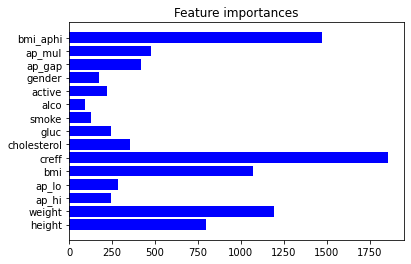

In [55]:
col_list = []
importance_list = []
for c, v in zip(assembler.getInputCols(), xgc_model.get_feature_importances().values()):
    col_list.append(c)
    importance_list.append(v)
    print('col: %s'%c, 'importance: %.1f'%v)

plt.figure()
plt.title("Feature importances")
plt.barh(col_list, importance_list, color="b")
plt.show()

In [56]:
xgc_model.get_booster().dump_model('xgb_model.txt', with_stats=True)

In [57]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Create both evaluators
evaluatorMulti = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction", metricName='areaUnderROC')

# Make predicitons
predictionAndTarget = xgc_model.transform(test_data).select("label", "prediction")

# Get metrics
acc = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "accuracy"})
f1 = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "f1"})
weightedPrecision = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecall = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedRecall"})
auc = evaluator.evaluate(predictionAndTarget)
print('acc:', acc)
print('recall:', weightedRecall)
print('f1:', f1)
print('auc:', auc)

2023-10-12 03:13:20,047 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2023-10-12 03:13:20,127 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2023-10-12 03:13:20,352 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2023-10-12 03:13:20,416 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2023-10-12 03:13:22,872 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2023-10-12 03:13:22,922 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2023-10-12 03:13:23,392 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2023-10-12 03:13:23,506 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2023-10-12 03:13:25,760 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2023-10-12 03:13:25,762 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2023-10-12 03:13:26,193 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2023-10-12 03:13:26,287 INFO XGBoost-PySpar

acc: 0.7190043082814744
recall: 0.7190043082814743
f1: 0.7182813611008362
auc: 0.7190611693270365


In [58]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

# Scala version implements .roc() and .pr()
# Python: https://spark.apache.org/docs/latest/api/python/_modules/pyspark/mllib/common.html
# Scala: https://spark.apache.org/docs/latest/api/java/org/apache/spark/mllib/evaluation/BinaryClassificationMetrics.html
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
2023-10-12 03:14:00,983 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2023-10-12 03:14:01,848 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2023-10-12 03:14:01,909 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2023-10-12 03:14:02,997 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2023-10-12 03:14:03,001 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


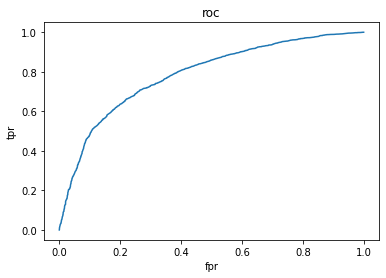

In [59]:
predictions = xgc_model.transform(test_data)
preds = predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('roc')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.plot(x_val, y_val)